## Print the final results

In [1]:
import os
import json
import pandas as pd

'''
{baseline_tag: 
    { 
        eval_dataset:{ }
                        
    }
}
'''

all_results = {}  

### full results print ####

# baseline_tags = ['random', 'diversity', 'label', 'filtered']
# eval_dataset_lists = ['mmlu', 'bbh',  'tydiqa', 'gsm', 'truthfulqa', 'codex_humaneval']
# eval_metrics = ['average_acc', 'average_exact_match',  "average""f1", "exact_match", "truth-info acc", "pass@10" ]


root_result_path = 'logs-llama3.1-8b/evaluation_result/results'

# Baseline tags and datasets
train_dataset = 'all_train'

# base_model ='meta-llama/Llama-2-7b-hf'
base_model ="meta-llama/Meta-Llama-3.1-8B" 
# base_model='mistralai/Mistral-7B-v0.3'
#

# labeling_model="meta-llama/Meta-Llama-3.1-8B-Instruct"
# labeling_model="gpt-4o-mini"
labeling_model='mistralai/Mistral-7B-Instruct-v0.3'



eval_dataset_lists = ['mmlu', 'truthfulqa', 'gsm', 'bbh', 'tydiqa' ]
# baseline_tags=['base','random',  'completion', 'perplexity',  'knn',  'label-filtered', 'diversity-filtered', 'less', 'filtered', 'full'] #baselines

baseline_tags=[ 'label-filtered', 'diversity-filtered', 'filtered'] #baselines

# Load results from JSON files
for tag in baseline_tags:
    baseline_results = {}
    for eval_dataset in eval_dataset_lists:
        path = root_result_path + f'/{labeling_model}/{train_dataset}/{eval_dataset}/{base_model}/{tag}/metrics.json'
        try:
            with open(path, 'r') as f:
                json_file = json.load(f)
            baseline_results[eval_dataset] = json_file
        except FileNotFoundError:
            print(f"Failed to find the file at {path}")
            baseline_results[eval_dataset] = None

    all_results[tag] = baseline_results

# Extract relevant metrics and store in a DataFrame
cur_results = {}
for tag in baseline_tags:
    baseline_result = []
    for eval_dataset in eval_dataset_lists:
        if all_results[tag][eval_dataset] is None:
            value = None
        else:
            if eval_dataset == 'mmlu':
                value = round(all_results[tag][eval_dataset]['average_acc'] * 100, 1)
            elif eval_dataset == 'bbh':
                value = round(all_results[tag][eval_dataset]['average_exact_match']* 100, 1)
            elif eval_dataset == 'tydiqa':
                value = round(all_results[tag][eval_dataset]['average']['f1'], 1)
            elif eval_dataset == 'gsm':
                value = round(all_results[tag][eval_dataset]['exact_match']* 100, 1)
            elif eval_dataset == 'truthfulqa':
                value = round(all_results[tag][eval_dataset]["truth-info acc"]* 100, 1)
            else:
                print("unknown eval dataset!")


        baseline_result.append(value)
    cur_results[tag] = baseline_result

# Convert cur_results to pandas DataFrame
df_results = pd.DataFrame.from_dict(cur_results, orient='index', columns=eval_dataset_lists)

# Calculate the average accuracy for each baseline
df_results['average acc'] = df_results.mean(axis=1).round(1)
print(f"### base_model: {base_model}")
print(f"### labeling_model: {labeling_model}")
print(df_results)


### base_model: mistralai/Mistral-7B-v0.3
### labeling_model: mistralai/Mistral-7B-Instruct-v0.3
                    mmlu  truthfulqa   gsm   bbh  tydiqa  average acc
label-filtered      59.1        39.5  46.0  53.2    53.9         50.3
diversity-filtered  60.1        36.5  42.5  56.8    54.6         50.1
filtered            59.5        40.4  43.0  51.4    49.8         48.8


## Azure openAI API KEY Check

In [41]:
import os
from openai import AzureOpenAI

client = AzureOpenAI(
    api_key='a35b8b00d740422590852f08ed15f8b0',
    api_version="2024-02-01",
    azure_endpoint="https://gpt-4o-mini-exp.openai.azure.com/"
)

# This will correspond to the custom name you chose for your deployment when you deployed a model.
# Use a gpt-35-turbo-instruct deployment.
# deployment_name = "gpt-4o-2024-05-13"

deployment_name="gpt-4-turbo-2024-04-09"


batch_messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Tell me a short story about a brave knight."}
]


# Send a completion call to generate an answer
prompt = "hi\n"
completions = client.chat.completions.create(
    model=deployment_name,
    messages=batch_messages,
    max_tokens=16
)

# print(completion)
GPT_content = '### Rating:'
# for chunk in completion:
#     if chunk.choices and chunk.choices[0].message.content is not None:
#         GPT_content += chunk.choices[0].message.content

if completions.choices and completions.choices[0].message.content is not None:
    GPT_content += completion.choices[0].message.content
print(GPT_content)

### Rating:In the heart of the ancient kingdom of Eldoria, where dragons soared and whispers


In [29]:
completion.choices[0].content_filter_results

{'hate': {'filtered': False, 'severity': 'safe'},
 'protected_material_code': {'filtered': False, 'detected': False},
 'protected_material_text': {'filtered': False, 'detected': False},
 'self_harm': {'filtered': False, 'severity': 'safe'},
 'sexual': {'filtered': False, 'severity': 'safe'},
 'violence': {'filtered': False, 'severity': 'safe'}}

### Contatenate labels from API CAlling

In [73]:
import torch 


dataset_name = 'oasst1'
file_path = f'./logs-api/gpt-4o-mini-2024-08-28/{dataset_name}/'
idxs=34

tot_labels = []
for idx in range(idxs):
    batch_labels =  torch.load(file_path + f"output_labels_{idx}.pt")
    tot_labels.extend(batch_labels)

tot_labels = [label if label is not None else [0, 0, 0, 0] for label in tot_labels]


torch.save(tot_labels, file_path + "total_output_labels.pt")


In [74]:
len(tot_labels)

33919

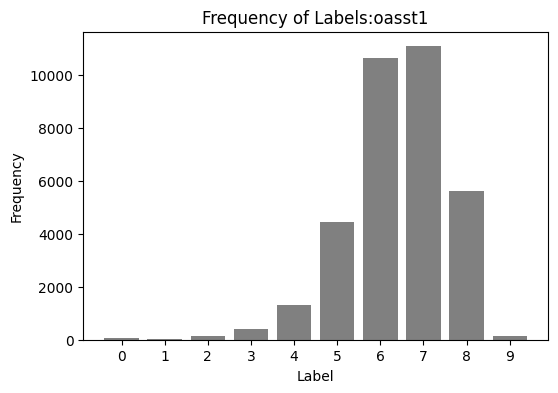

In [75]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

counter = Counter(np.array(tot_labels)[:,-1].tolist())


labels, counts = zip(*counter.items())

# 绘制柱状图
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color='gray')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title(f'Frequency of Labels:{dataset_name}')
plt.xticks(labels)  # 显示所有的标签
plt.show()

### Concatenate GPT_Labeling

Dataset flan_v2 size: 100000 -- : Revised Counter({2: 36454, 3: 35613, 1: 15071, 4: 8112, 0: 4645, 5: 105}) 

Dataset oasst1 size: 33919 -- : Revised Counter({3: 11093, 2: 10665, 4: 5620, 1: 4457, 0: 1932, 5: 152}) 

Dataset wizardlm size: 100000 -- : Revised Counter({4: 43489, 3: 29644, 2: 15177, 1: 5586, 5: 3483, 0: 2621}) 

Dataset dolly size: 15011 -- : Revised Counter({2: 5212, 3: 3608, 1: 3314, 4: 1656, 0: 1154, 5: 67}) 

Dataset stanford_alpaca size: 52002 -- : Revised Counter({2: 18624, 1: 15973, 0: 8274, 3: 8017, 4: 1092, 5: 22}) 

总共加载了 300932 个标签。
total count: Counter({3: 87975, 2: 86132, 4: 59969, 1: 44401, 0: 18626, 5: 3829})


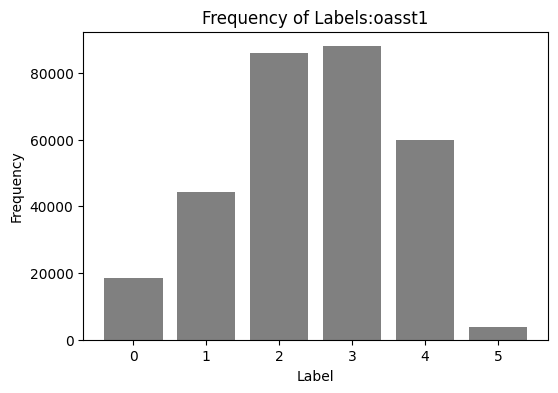

In [84]:
import os
import torch
from collections import Counter
from datasets import load_dataset, concatenate_datasets, Dataset
import matplotlib.pyplot as plt

# 定义数据集列表
DATASET_LIST = ['flan_v2', 'oasst1', 'wizardlm', 'dolly', 'stanford_alpaca']



# 定义主目录路径
base_dir = f'./logs-api/gpt-4o-mini-2024-08-28'


# 用于保存所有数据的列表
all_labels = []

# 遍历每个数据集
for dataset in DATASET_LIST:
    labels_path = os.path.join(base_dir, dataset, 'total_output_labels.pt')
    
    if os.path.exists(labels_path):
        # 加载并扩展文件内容
        original_labels = torch.load(labels_path)
        original_labels = [label[-1] for label in original_labels]
        labels_revised = []
        for label in original_labels:
            if label < 4:
                labels_revised.append(4)
            elif label >= 10:
                labels_revised.append(9)
            else:
                labels_revised.append(label)

        labels_revised = [label - 4 for label in labels_revised] #rematching

        label_counts_revised = Counter(labels_revised)
        print(f"Dataset {dataset} size: {len(labels_revised)} -- : Revised {label_counts_revised} \n")

        all_labels.extend(labels_revised)

    else:
        print(f"Cannot found the {labels_path}")

# 打印或处理汇总后的标签数据
print(f"总共加载了 {len(all_labels)} 个标签。")


if not os.path.exists(base_dir + f"/all_train/"):
    os.mkdir(base_dir + f"/all_train/")

torch.save(all_labels, base_dir + f"/all_train/total_output_labels.pt")

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

counter = Counter(all_labels)
print(f"total count: {counter}")

labels, counts = zip(*counter.items())

# 绘制柱状图
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color='gray')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title(f'Frequency of Labels:{dataset_name}')
plt.xticks(labels)  # 显示所有的标签
plt.show()



In [12]:
import torch
from collections import defaultdict
import random
import numpy as np

seed = 3
random.seed(3)
np.random.seed(3)

#llama labels
model_full_name ='meta-llama/Meta-Llama-3.1-8B-Instruct/'
new_train_dir = f"./zzzz_finetune_model/new_train_data/{model_full_name}"
output_file = os.path.join(new_train_dir, 'all_train/output_labels_revised.pt')
llama_labels= torch.load(output_file)


llama_labels_dict = defaultdict(list)
for index, label in enumerate(llama_labels):
    llama_labels_dict[label].append(index)


##GPT 4o-mini labels
base_dir = f'./logs-api/gpt-4o-mini'
gpt_labels = torch.load(base_dir + f"/all_train/total_output_labels.pt")


gpt_labels_dict = defaultdict(list)
for index, label in enumerate(gpt_labels):
    gpt_labels_dict[label].append(index)

#mistral labels
model_full_name='mistralai/Mistral-7B-Instruct-v0.3'
new_train_dir = f"./zzzz_finetune_model/new_train_data/{model_full_name}"
output_file = os.path.join(new_train_dir, 'all_train/output_labels_revised.pt')
mistral_labels= torch.load(output_file)


mistral_labels_dict = defaultdict(list)
for index, label in enumerate(mistral_labels):
    mistral_labels_dict[label].append(index)



intersection_all_dict = {}

for label in [5,4,3,2,1]:
    intersection_gpt_llama = set(gpt_labels_dict[label]) & set(llama_labels_dict[label])
    intersection_gpt_mistral = set(gpt_labels_dict[label]) & set(mistral_labels_dict[label])
    intersection_llama_mistral = set(llama_labels_dict[label]) & set(mistral_labels_dict[label])
    intersection_all_dict[label] = intersection_gpt_llama & intersection_gpt_mistral & intersection_llama_mistral
    print(f"intersection_all: {len(intersection_all_dict[label])} --- intersection_gpt_llama size: {len(intersection_gpt_llama)} -- intersection_gpt_mistral size: {len(intersection_gpt_mistral)} -- intersection_llama_mistral size:{len(intersection_llama_mistral)}")


dataset_size = 10000
combined_label_indices = set(llama_labels_dict[5] + mistral_labels_dict[5] + gpt_labels_dict[5])

additional_label_indices = random.sample(intersection_all_dict[4], dataset_size-len(combined_label_indices))


ideal_label_indices = list(combined_label_indices) + additional_label_indices




intersection_all: 10 --- intersection_gpt_llama size: 229 -- intersection_gpt_mistral size: 118 -- intersection_llama_mistral size:36
intersection_all: 12777 --- intersection_gpt_llama size: 22038 -- intersection_gpt_mistral size: 30098 -- intersection_llama_mistral size:22828
intersection_all: 16905 --- intersection_gpt_llama size: 36791 -- intersection_gpt_mistral size: 38831 -- intersection_llama_mistral size:49473
intersection_all: 4692 --- intersection_gpt_llama size: 16237 -- intersection_gpt_mistral size: 22525 -- intersection_llama_mistral size:12682
intersection_all: 2661 --- intersection_gpt_llama size: 11576 -- intersection_gpt_mistral size: 9146 -- intersection_llama_mistral size:9712


In [18]:
from datasets import load_dataset
import random
import numpy as np

seed =3
random.seed(seed)
np.random.seed(seed)

#### 
dataset_size = 10000
dataset_name ='all_train'
model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"


json_dir = './data/train_data/'

all_train_dataset = load_dataset('json', data_files=json_dir+'all_train_data.jsonl')['train']




random_indices = np.random.permutation(len(all_train_dataset))[:dataset_size]

random_dataset = all_train_dataset.select(ideal_label_indices)

root_path = f"./zzzz_finetune_model/new_train_data/{model_name}/{dataset_name}/"

random_dataset.to_json(root_path + f"combined_dataset.json")


In [19]:
len(ideal_label_indices)

10000

In [14]:
len(combined_label_indices)

8050

In [12]:
from collections import Counter


Counter(mistral_labels)

Counter({3: 118313, 2: 60607, 1: 52908, 4: 66181, 0: 2436, 5: 487})

In [19]:
import os
import json
import pandas as pd
import fire
'''
{baseline_tag: 
    { 
        eval_dataset:{ }
                        
    }
}
'''

def main(
        root_result_path = 'data_scale_result_seed43',
        train_dataset='all_train',
        base_model = "meta-llama/Meta-Llama-3.1-8B",
        labeling_model='mistralai/Mistral-7B-Instruct-v0.3',
        baseline_tag = 'filtered', 
        ):

    all_results = {}  

    ### full results print ####

    labeling_models = ["meta-llama/Meta-Llama-3.1-8B-Instruct","gpt-4o-mini", 'mistralai/Mistral-7B-Instruct-v0.3']
    final_df_pivot = pd.DataFrame()  # 用于存储所有拼接的结果

    for labeling_model in labeling_models:
        # labeling_model ="meta-llama/Meta-Llama-3.1-8B-Instruct" 
        # # labeling_model="gpt-4o-mini"
        # labeling_model='mistralai/Mistral-7B-Instruct-v0.3'


        # baseline_tags=['base','random',  'completion', 'perplexity',  'knn',  'label-filtered', 'diversity-filtered', 'less', 'filtered', 'full'] #baselines
        data_scales = ['2k', '5k', '10k', '20k', '40k']


        if 'llama' in labeling_model.lower():
            baseline_tags=['random', 'less', 'label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.4'] ##llama
        else:
            baseline_tags=['label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.5'] ##llama

        # baseline_tags=['random', 'less', 'filtered'] 

        eval_dataset_lists = ['mmlu', 'truthfulqa', 'gsm', 'bbh', 'tydiqa' ]

        # Load results from JSON files
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_results = {}
                for eval_dataset in eval_dataset_lists:
                    path = root_result_path + f'/results/{labeling_model}/{train_dataset}/{eval_dataset}/{base_model}/{tag}-{data_scale}/metrics.json'
                    try:
                        with open(path, 'r') as f:
                            json_file = json.load(f)
                        baseline_results[eval_dataset] = json_file
                    except FileNotFoundError:
                        print(f"Failed to find the file at {path}")
                        baseline_results[eval_dataset] = None

                all_results[f'{tag}-{data_scale}'] = baseline_results

        # Extract relevant metrics and store in a DataFrame
        cur_results = {}
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_result = []
                baseline_name=f'{tag}-{data_scale}'
                for eval_dataset in eval_dataset_lists:
                    if all_results[baseline_name][eval_dataset] is None:
                        value = 0
                    else:
                        if eval_dataset == 'mmlu':
                            value = round(all_results[baseline_name][eval_dataset]['average_acc'] * 100, 1)
                        elif eval_dataset == 'bbh':
                            value = round(all_results[baseline_name][eval_dataset]['average_exact_match']* 100, 1)
                        elif eval_dataset == 'tydiqa':
                            value = round(all_results[baseline_name][eval_dataset]['average']['f1'], 1)
                        elif eval_dataset == 'gsm':
                            value = round(all_results[baseline_name][eval_dataset]['exact_match']* 100, 1)
                        elif eval_dataset == 'truthfulqa':
                            value = round(all_results[baseline_name][eval_dataset]["truth-info acc"]* 100, 1)
                        else:
                            print("unknown eval dataset!")


                    baseline_result.append(value)
                cur_results[baseline_name] = baseline_result

        # Convert cur_results to pandas DataFrame
        df_results = pd.DataFrame.from_dict(cur_results, orient='index', columns=eval_dataset_lists)

        # Calculate the average accuracy for each baseline
        df_results['average acc'] = df_results.mean(axis=1).round(1)

        # print(df_results['average acc'])
        print(f"### base_model: {base_model}")
        print(f"### labeling_model: {labeling_model}")


        # Ensure full display of the DataFrame
        pd.set_option('display.max_rows', None)  # Show all rows
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)  # Set display width
        pd.set_option('display.max_colwidth', None)  # Set max column width

        # print(df_results)

        df_avg_acc = df_results['average acc']

        # Split the index into baseline_tags and data_scales
        df_avg_acc.index = pd.MultiIndex.from_tuples([idx.rsplit('-', 1) for idx in df_avg_acc.index], names=['baseline_tag', 'data_scale'])

        # Pivot the table to get baseline_tags as rows and data_scales as columns
        df_pivot = df_avg_acc.unstack(level='data_scale')
        df_pivot = df_pivot.reindex(index=baseline_tags, columns=data_scales)

        # Ensure full display of the DataFrame
        pd.set_option('display.max_rows', None)  # Show all rows
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)  # Set display width
        pd.set_option('display.max_colwidth', None)  # Set max column width

        # 输出结果
        print(df_pivot)



if __name__ == '__main__':
    fire.Fire(main)


### base_model: meta-llama/Meta-Llama-3.1-8B
### labeling_model: meta-llama/Meta-Llama-3.1-8B-Instruct
data_scale            2k    5k   10k   20k   40k
baseline_tag                                    
random              54.5  54.1  57.8  56.4  56.9
less                49.1  53.3  57.7  58.6  57.2
label-filtered      45.2  48.0  46.8  52.8  54.1
diversity-filtered  49.6  50.7  56.0  56.9  56.4
filtered            57.7  57.0  58.7  58.7  58.0
filtered-cured-0.4  58.0  58.4  60.1  60.6  58.6


ERROR: Could not consume arg: --f=/home/azureuser/.local/share/jupyter/runtime/kernel-v2-205297bVV4qlmnWla5.json
Usage: ipykernel_launcher.py -

For detailed information on this command, run:
  ipykernel_launcher.py - --help


FireExit: 2

/anaconda/envs/new_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [51]:
import os
import json
import pandas as pd
import fire

def main(
        seed=43,
        root_result_path='data_scale_result_seed',
        train_dataset='all_train',
        base_model="meta-llama/Meta-Llama-3.1-8B",
        labeling_model='mistralai/Mistral-7B-Instruct-v0.3',
    ):


    root_result_path = root_result_path + str(seed)
    all_results = {}  

    ### full results print ####

    labeling_models = ["meta-llama/Meta-Llama-3.1-8B-Instruct", "gpt-4o-mini", 'mistralai/Mistral-7B-Instruct-v0.3']

    final_df_pivot = pd.DataFrame()  # 用于存储所有拼接的结果

    for labeling_model in labeling_models:

        # baseline_tags 和 data_scales 的设置
        data_scales = ['2k', '5k', '10k', '20k', '40k']


        if 'llama' in labeling_model.lower():
            baseline_tags = ['random', 'less', 'label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.4']  # llama 模型的标签
        else:
            baseline_tags = ['label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.5']  # 其他模型的标签

        eval_dataset_lists = ['mmlu', 'truthfulqa', 'gsm', 'bbh', 'tydiqa']

        # 从 JSON 文件加载结果
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_results = {}
                for eval_dataset in eval_dataset_lists:
                    path = root_result_path + f'/results/{labeling_model}/{train_dataset}/{eval_dataset}/{base_model}/{tag}-{data_scale}/metrics.json'
                    try:
                        with open(path, 'r') as f:
                            json_file = json.load(f)
                        baseline_results[eval_dataset] = json_file
                    except FileNotFoundError:
                        print(f"Failed to find the file at {path}")
                        baseline_results[eval_dataset] = None

                all_results[f'{tag}-{data_scale}'] = baseline_results

        # 提取相关的度量并存储到 DataFrame
        cur_results = {}
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_result = []
                baseline_name = f'{tag}-{data_scale}'
                for eval_dataset in eval_dataset_lists:
                    if all_results[baseline_name][eval_dataset] is None:
                        value = 0
                    else:
                        if eval_dataset == 'mmlu':
                            value = round(all_results[baseline_name][eval_dataset]['average_acc'] * 100, 1)
                        elif eval_dataset == 'bbh':
                            value = round(all_results[baseline_name][eval_dataset]['average_exact_match'] * 100, 1)
                        elif eval_dataset == 'tydiqa':
                            value = round(all_results[baseline_name][eval_dataset]['average']['f1'], 1)
                        elif eval_dataset == 'gsm':
                            value = round(all_results[baseline_name][eval_dataset]['exact_match'] * 100, 1)
                        elif eval_dataset == 'truthfulqa':
                            value = round(all_results[baseline_name][eval_dataset]["truth-info acc"] * 100, 1)
                        else:
                            print("Unknown eval dataset!")

                    baseline_result.append(value)
                cur_results[baseline_name] = baseline_result

        # 将 cur_results 转换为 pandas DataFrame
        df_results = pd.DataFrame.from_dict(cur_results, orient='index', columns=eval_dataset_lists)

        # 计算每个基线的平均准确率
        df_results['average acc'] = df_results.mean(axis=1).round(1)

        # 将索引拆分为 baseline_tags 和 data_scales
        df_results.index = pd.MultiIndex.from_tuples([idx.rsplit('-', 1) for idx in df_results.index], names=['baseline_tag', 'data_scale'])

        # 透视表，基线标签为行，数据规模为列
        df_pivot = df_results['average acc'].unstack(level='data_scale')
        df_pivot = df_pivot.reindex(index=baseline_tags, columns=data_scales)

        # 为每个 df_pivot 添加 labeling_model 的层级索引
        df_pivot['labeling_model'] = labeling_model.split('/')[-1]
        df_pivot = df_pivot.set_index('labeling_model', append=True)

        # 将当前的 df_pivot 拼接到最终的 DataFrame
        final_df_pivot = pd.concat([final_df_pivot, df_pivot])


    final_df_pivot['0k'] = 46.6
    final_df_pivot['300k'] = 57.7

    # 重新排列列的顺序，如果需要的话可以让 '0k' 和 '300k' 置于合适的位置
    cols = ['0k'] + [col for col in final_df_pivot.columns if col not in ['0k', '300k']] + ['300k']
    final_df_pivot = final_df_pivot[cols]

    # 确保完全显示 DataFrame
    pd.set_option('display.max_rows', None)  # 显示所有行
    pd.set_option('display.max_columns', None)  # 显示所有列
    pd.set_option('display.width', 1000)  # 设置显示宽度
    pd.set_option('display.max_colwidth', None)  # 设置最大列宽

    # 输出拼接后的最终结果
    print(f"##### Data scaling file: {root_result_path} #####")
    print(final_df_pivot)

    final_df_pivot.to_csv(root_result_path + '/data_scaling_average.csv')


if __name__ == '__main__':
    fire.Fire(main)


data_scale                                       0k    2k    5k   10k   20k   40k  300k
baseline_tag       labeling_model                                                      
random             Meta-Llama-3.1-8B-Instruct  46.6  54.5  54.1  57.8  56.4  56.9  57.7
less               Meta-Llama-3.1-8B-Instruct  46.6  49.1  53.3  57.7  58.6  57.2  57.7
label-filtered     Meta-Llama-3.1-8B-Instruct  46.6  45.2  48.0  46.8  52.8  54.1  57.7
diversity-filtered Meta-Llama-3.1-8B-Instruct  46.6  49.6  50.7  56.0  56.9  56.4  57.7
filtered           Meta-Llama-3.1-8B-Instruct  46.6  57.7  57.0  58.7  58.7  58.0  57.7
filtered-cured-0.4 Meta-Llama-3.1-8B-Instruct  46.6  58.0  58.4  60.1  60.6  58.6  57.7
label-filtered     gpt-4o-mini                 46.6  47.6  47.2  50.6  56.3  53.4  57.7
diversity-filtered gpt-4o-mini                 46.6  50.3  51.8  58.9  58.0  57.7  57.7
filtered           gpt-4o-mini                 46.6  58.5  59.9  60.3  59.4  57.9  57.7
filtered-cured-0.5 gpt-4o-mini  

ERROR: Could not consume arg: --f=/home/azureuser/.local/share/jupyter/runtime/kernel-v2-205297bVV4qlmnWla5.json
Usage: ipykernel_launcher.py -

For detailed information on this command, run:
  ipykernel_launcher.py - --help


FireExit: 2

/anaconda/envs/new_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# LlaMA-3.1-8B-Instruct
random_results_llama = [46.6, 55.4, 54.6, 56.5, 56.5, 58.0, 57.7]
label_filtered_results_llama = [46.6, 47.4, 45.0, 58.1, 49.7,  56.3, 57.7]
diversity_filtered_results_llama = [46.6, 50.4, 51.0, 56.6, 57.7, 56.4, 57.7]
less_results_llama = [46.6, 48.8, 56.0, 58.0, 58.5, 57.4, 57.7]
filtered_results_llama = [46.6, 58.5, 56.4, 59.2, 59.3, 58.5, 57.7]
filtered_cured_results_llama = [46.6, 58.3, 58.8, 60.2, 59.7, 58.0, 57.7]

# GPT-4o-mini
label_filtered_results_gpt = [46.6, 47.7, 48.3, 58.1, 55.5, 55.2, 57.7]
diversity_filtered_results_gpt = [46.6, 51.0, 50.7, 56.6, 57.6, 55.4, 57.7]
filtered_results_gpt = [46.6, 59.3, 59.3, 60.2, 58.5, 58.8, 57.7]
filtered_cured_results_gpt = [46.6, 57.3, 57.7, 61.4, 59.3, 60.4, 57.7]


# Mistral-7B-v0.3
label_filtered_results_mistral = [46.6, 50.6, 53.3, 58.1, 57.1, 57.2, 57.7]
diversity_filtered_results_mistral = [46.6, 49.6, 56.1, 56.6, 58.2, 57.5, 57.7]
filtered_results_mistral = [46.6, 55.2, 60.4, 60.7, 59.3, 60.9, 57.7]
filtered_cured_results_mistral = [46.6, 56.0, 58.7, 61.1, 60.6, 58.5, 57.7]



In [49]:
import pandas as pd

##### data_scale_result_seed 42


data = {
    "Meta-Llama-3.1-8B-Instruct": {
        "random": [46.6, 55.4, 54.6, 56.5, 56.5, 58.0, 57.7],
        "less": [46.6, 48.8, 56.0, 58.0, 58.5, 57.4, 57.7],
        "label-filtered": [46.6, 47.4, 45.0, 58.1, 49.7,  56.3, 57.7],
        "diversity-filtered": [46.6, 50.4, 51.0, 56.6, 57.7, 56.4, 57.7],
        "filtered": [46.6, 58.5, 56.4, 59.2, 59.3, 58.5, 57.7],
        "filtered-cured-0.4": [46.6, 58.3, 58.8, 60.2, 59.7, 58.0, 57.7],
    },
    "gpt-4o-mini": {
        "label-filtered": [46.6, 47.7, 48.3, 58.1, 55.5, 55.2, 57.7],
        "diversity-filtered": [46.6, 51.0, 50.7, 56.6, 57.6, 55.4, 57.7],
        "filtered": [46.6, 59.3, 59.3, 60.2, 58.5, 58.8, 57.7],
        "filtered-cured-0.5": [46.6, 57.3, 57.7, 61.4, 59.3, 60.4, 57.7],
    },
    "Mistral-7B-Instruct-v0.3": {
        "label-filtered": [46.6, 50.6, 53.3, 58.1, 57.1, 57.2, 57.7],
        "diversity-filtered": [46.6, 49.6, 56.1, 56.6, 58.2, 57.5, 57.7],
        "filtered": [46.6, 55.2, 60.4, 60.7, 59.3, 60.9, 57.7],
        "filtered-cured-0.5": [46.6, 56.0, 58.7, 61.1, 60.6, 58.5, 57.7],
    }
}

# 将数据转换为 pandas DataFrame
df = pd.DataFrame.from_dict({(method, model): values 
                             for model, methods in data.items() 
                             for method, values in methods.items()},
                            orient='index',
                            columns=['0k', '2k', '5k', '10k', '20k', '40k', '300k'])

# 将 multi-index 分成两列 baseline_tag 和 labeling_model
df.index = pd.MultiIndex.from_tuples(df.index, names=['baseline_tag', 'labeling_model'])

# 显示生成的 DataFrame
print(df)

# 保存为 CSV 文件
df.to_csv('data_scale_result_seed42/data_scaling_average.csv')


                                                 0k    2k    5k   10k   20k   40k  300k
baseline_tag       labeling_model                                                      
random             Meta-Llama-3.1-8B-Instruct  46.6  55.4  54.6  56.5  56.5  58.0  57.7
less               Meta-Llama-3.1-8B-Instruct  46.6  48.8  56.0  58.0  58.5  57.4  57.7
label-filtered     Meta-Llama-3.1-8B-Instruct  46.6  47.4  45.0  58.1  49.7  56.3  57.7
diversity-filtered Meta-Llama-3.1-8B-Instruct  46.6  50.4  51.0  56.6  57.7  56.4  57.7
filtered           Meta-Llama-3.1-8B-Instruct  46.6  58.5  56.4  59.2  59.3  58.5  57.7
filtered-cured-0.4 Meta-Llama-3.1-8B-Instruct  46.6  58.3  58.8  60.2  59.7  58.0  57.7
label-filtered     gpt-4o-mini                 46.6  47.7  48.3  58.1  55.5  55.2  57.7
diversity-filtered gpt-4o-mini                 46.6  51.0  50.7  56.6  57.6  55.4  57.7
filtered           gpt-4o-mini                 46.6  59.3  59.3  60.2  58.5  58.8  57.7
filtered-cured-0.5 gpt-4o-mini  

In [87]:
import os
import pandas as pd

seeds = [42, 43, 44]

all_results = {}

# 读取所有种子对应的 CSV 文件并存储在字典中
for seed in seeds:
    file_path = f"data_scale_result_seed{seed}/data_scaling_average.csv"
    df = pd.read_csv(file_path, index_col=[0, 1])  # 假设 CSV 文件有两个索引列
    all_results[seed] = df

# 获取第一个种子文件的索引顺序作为原有顺序
original_order = all_results[seeds[0]].index

# 将所有数据合并到一个 DataFrame 中
df_all = pd.concat(all_results.values(), keys=all_results.keys(), names=['seed'])

# 计算平均值和标准差
df_mean = df_all.groupby(level=[1, 2]).mean()
df_std = df_all.groupby(level=[1, 2]).std()

# 使用原有顺序重新排列
df_mean = df_mean.reindex(original_order)
df_std = df_std.reindex(original_order)

# 保留两位小数
df_mean_rounded = df_mean.round(2)
df_std_rounded = df_std.round(2)

# 输出保留两位小数的平均值和标准差
print("保留两位小数的平均值：")
print(df_mean_rounded)
print("\n保留两位小数的标准差：")
print(df_std_rounded)

# 保存保留两位小数的结果到 CSV 文件
df_mean_rounded.to_csv("data_scaling_final_average.csv")
df_std_rounded.to_csv("data_scaling_final_std.csv")


保留两位小数的平均值：
                                                 0k     2k     5k    10k    20k    40k  300k
baseline_tag       labeling_model                                                           
random             Meta-Llama-3.1-8B-Instruct  46.6  54.50  54.80  57.43  55.93  57.13  57.7
less               Meta-Llama-3.1-8B-Instruct  46.6  48.83  54.63  57.50  58.80  57.53  57.7
label-filtered     Meta-Llama-3.1-8B-Instruct  46.6  45.77  46.47  50.47  51.20  54.20  57.7
diversity-filtered Meta-Llama-3.1-8B-Instruct  46.6  50.03  50.93  56.30  57.00  56.80  57.7
filtered           Meta-Llama-3.1-8B-Instruct  46.6  58.10  56.97  58.57  59.33  57.93  57.7
filtered-cured-0.4 Meta-Llama-3.1-8B-Instruct  46.6  57.30  58.23  60.13  59.73  58.37  57.7
label-filtered     gpt-4o-mini                 46.6  47.57  48.03  53.17  55.77  54.50  57.7
diversity-filtered gpt-4o-mini                 46.6  50.47  51.13  58.33  57.63  57.03  57.7
filtered           gpt-4o-mini                 46.6  58.73

In [90]:
df_mean_rounded

,baseline_tag,labeling_model,0k,2k,5k,10k,20k,40k,300k
0,random,Meta-Llama-3.1-8B-Instruct,46.6,54.50,54.80,57.43,55.93,57.13,57.7
1,less,Meta-Llama-3.1-8B-Instruct,46.6,48.83,54.63,57.50,58.80,57.53,57.7
2,label-filtered,Meta-Llama-3.1-8B-Instruct,46.6,45.77,46.47,50.47,51.20,54.20,57.7
3,diversity-filtered,Meta-Llama-3.1-8B-Instruct,46.6,50.03,50.93,56.30,57.00,56.80,57.7
4,filtered,Meta-Llama-3.1-8B-Instruct,46.6,58.10,56.97,58.57,59.33,57.93,57.7
5,filtered-cured-0.4,Meta-Llama-3.1-8B-Instruct,46.6,57.30,58.23,60.13,59.73,58.37,57.7
6,label-filtered,gpt-4o-mini,46.6,47.57,48.03,53.17,55.77,54.50,57.7
7,diversity-filtered,gpt-4o-mini,46.6,50.47,51.13,58.33,57.63,57.03,57.7
8,filtered,gpt-4o-mini,46.6,58.73,59.60,60.17,59.00,58.13,57.7
9,filtered-cured-0.5,gpt-4o-mini,46.6,57.57,58.40,61.03,59.63,60.00,57.7


## plot the average result under three seeds

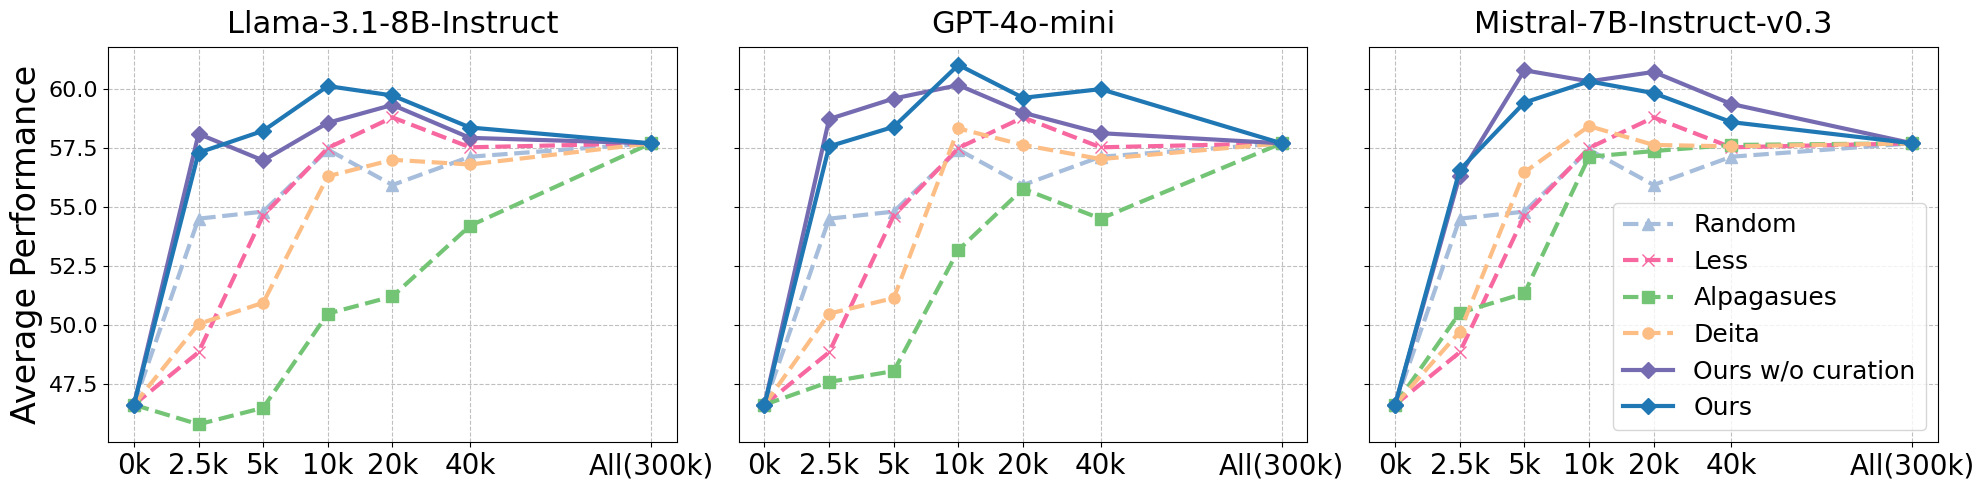

In [125]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件，并设置多级索引
df_mean_rounded = pd.read_csv("data_scaling_final_average.csv", index_col=[0, 1])  
df_std_rounded = pd.read_csv("data_scaling_final_std.csv", index_col=[0, 1])

# 获取 x 轴标签 (data scales)
# x_labels = df_mean_rounded.columns.tolist()
x_labels = [0, 5, 10, 15, 20, 26, 40]

# 根据 labeling_model 绘制三张曲线图
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

# 选取 labeling models
labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

# 绘制每个 labeling_model 的曲线图
for i, labeling_model in enumerate(labeling_models):
    # 获取该 labeling_model 对应的平均值数据
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    # 不管是否是 Meta-Llama-3.1-8B-Instruct, 都添加 random 和 less 曲线
    if labeling_model != 'Meta-Llama-3.1-8B-Instruct':
        df_subset_new = df_mean_rounded.xs('Meta-Llama-3.1-8B-Instruct', level='labeling_model')
        axes[i].plot(x_labels, df_subset_new.loc['random'], marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8)
        axes[i].plot(x_labels, df_subset_new.loc['less'], marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8)

    # 绘制每个 baseline_tag 对应的曲线
    for baseline_tag in df_subset.index:
        if baseline_tag == 'random':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8)
        elif baseline_tag == 'less':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8)
        elif baseline_tag == 'label-filtered':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='s', label='Alpagasues', linewidth=3, color='#74c476', linestyle='--', markersize=8)
        elif baseline_tag == 'diversity-filtered':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='o', label='Deita', linewidth=3, color='#fdbe85', linestyle='--', markersize=8)
        elif baseline_tag == 'filtered':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='D', label='Ours w/o curation', linewidth=3, color='#756bb1', linestyle='-', markersize=8)
        elif 'filtered-cured' in baseline_tag:
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='D', label='Ours', linewidth=3, color='#1f77b4', linestyle='-', markersize=8)


    # 设置子图标题和标签
    xticks_labels = ['0k', '2.5k', '5k', '10k', '20k', '40k', 'All(300k)']
   
    if 'llama' in labeling_model.lower():
        axes[i].set_title(f'Llama-3.1-8B-Instruct', fontsize=22, pad=10)

    if 'gpt' in labeling_model.lower():
        axes[i].set_title(f'GPT-4o-mini', fontsize=22, pad=10)

    if 'mistral' in labeling_model.lower():
        axes[i].set_title(f'Mistral-7B-Instruct-v0.3', fontsize=22, pad=10)

    axes[i].set_xticks(x_labels)
    axes[i].set_xticklabels(xticks_labels, fontsize=20)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.8)
    
    # 为每个子图添加图例
    if i==2:
        axes[i].legend(loc='lower right', fontsize=18)

# 设置共享的 y 轴标签
axes[0].set_ylabel('Average Performance', fontsize=24)
axes[0].tick_params(axis='y', labelsize=16)

# 显示图像
plt.tight_layout()
plt.show()


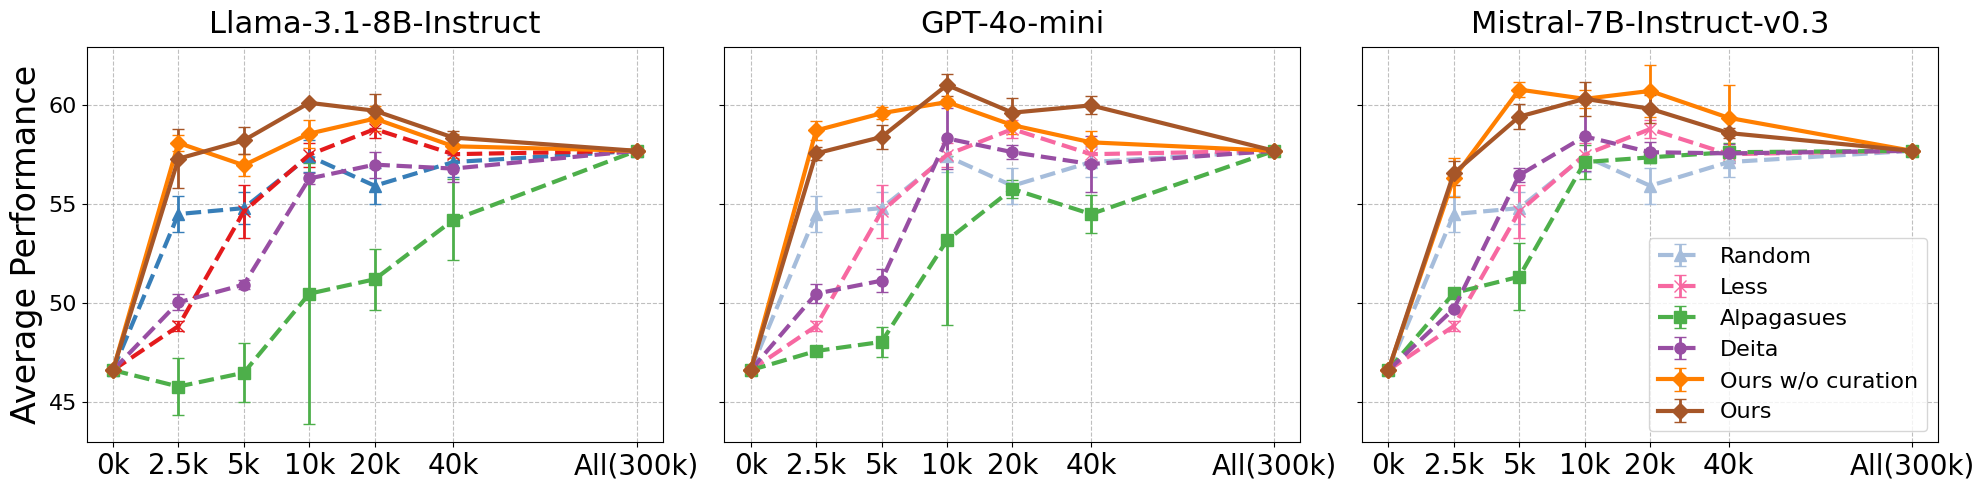

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件，并设置多级索引
df_mean_rounded = pd.read_csv("data_scaling_final_average.csv", index_col=[0, 1])  
df_std_rounded = pd.read_csv("data_scaling_final_std.csv", index_col=[0, 1])

# 获取 x 轴标签 (data scales)
x_labels = [0, 5, 10, 15, 20, 26, 40]  # 手动设置 x 轴的位置
xticks_labels = ['0k', '2.5k', '5k', '10k', '20k', '40k', 'All(300k)']  # x轴的显示标签

# 根据 labeling_model 绘制三张曲线图
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

# 选取 labeling models
labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

# 绘制每个 labeling_model 的曲线图
for i, labeling_model in enumerate(labeling_models):
    # 获取该 labeling_model 对应的平均值数据和标准差
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    df_std_subset = df_std_rounded.xs(labeling_model, level='labeling_model')
    
    # 不管是否是 Meta-Llama-3.1-8B-Instruct, 都添加 random 和 less 曲线
    if labeling_model != 'Meta-Llama-3.1-8B-Instruct':
        df_subset_new = df_mean_rounded.xs('Meta-Llama-3.1-8B-Instruct', level='labeling_model')
        df_std_new = df_std_rounded.xs('Meta-Llama-3.1-8B-Instruct', level='labeling_model')
        axes[i].errorbar(x_labels, df_subset_new.loc['random'], yerr=df_std_new.loc['random'],
                         marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        axes[i].errorbar(x_labels, df_subset_new.loc['less'], yerr=df_std_new.loc['less'],
                         marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8, capsize=4, elinewidth=2)

    # 绘制每个 baseline_tag 对应的曲线，并添加标准差
    for baseline_tag in df_subset.index:
        if baseline_tag == 'random':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'less':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'label-filtered':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='s', label='Alpagasues', linewidth=3, color='#74c476', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'diversity-filtered':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='o', label='Deita', linewidth=3, color='#fdbe85', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'filtered':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='D', label='Ours w/o curation', linewidth=3, color='#ff7f00', linestyle='-', markersize=8, capsize=4, elinewidth=2)
        elif 'filtered-cured' in baseline_tag:
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='D', label='Ours', linewidth=3, color='#a65628', linestyle='-', markersize=8, capsize=4, elinewidth=2)
            # 调整后的配色方案
        #     axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
        #                     marker='^', label='Random', linewidth=3, color='#377eb8', linestyle='--', markersize=8, capsize=4, elinewidth=2)  # 蓝色
        # elif baseline_tag == 'less':
        #     axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
        #                     marker='x', label='Less', linewidth=3, color='#e41a1c', linestyle='--', markersize=8, capsize=4, elinewidth=2)  # 红色
        # elif baseline_tag == 'label-filtered':
        #     axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
        #                     marker='s', label='Alpagasues', linewidth=3, color='#4daf4a', linestyle='--', markersize=8, capsize=4, elinewidth=2)  # 绿色
        # elif baseline_tag == 'diversity-filtered':
        #     axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
        #                     marker='o', label='Deita', linewidth=3, color='#984ea3', linestyle='--', markersize=8, capsize=4, elinewidth=2)  # 紫色
        # elif baseline_tag == 'filtered':
        #     axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
        #                     marker='D', label='Ours w/o curation', linewidth=3, color='#ff7f00', linestyle='-', markersize=8, capsize=4, elinewidth=2)  # 橙色
        # elif 'filtered-cured' in baseline_tag:
        #     axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
        #                     marker='D', label='Ours', linewidth=3, color='#a65628', linestyle='-', markersize=8, capsize=4, elinewidth=2)  # 棕色

    # 设置子图标题和标签
    if 'llama' in labeling_model.lower():
        axes[i].set_title(f'Llama-3.1-8B-Instruct', fontsize=22, pad=10)

    if 'gpt' in labeling_model.lower():
        axes[i].set_title(f'GPT-4o-mini', fontsize=22, pad=10)

    if 'mistral' in labeling_model.lower():
        axes[i].set_title(f'Mistral-7B-Instruct-v0.3', fontsize=22, pad=10)

    axes[i].set_xticks(x_labels)
    axes[i].set_xticklabels(xticks_labels, fontsize=20)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.8)
    
    # 为每个子图添加图例
    if i == 2:
        axes[i].legend(loc='lower right', fontsize=16)

# 设置共享的 y 轴标签
axes[0].set_ylabel('Average Performance', fontsize=24)
axes[0].tick_params(axis='y', labelsize=16)

# 显示图像
plt.tight_layout()
plt.show()


### Plot the stability of curation

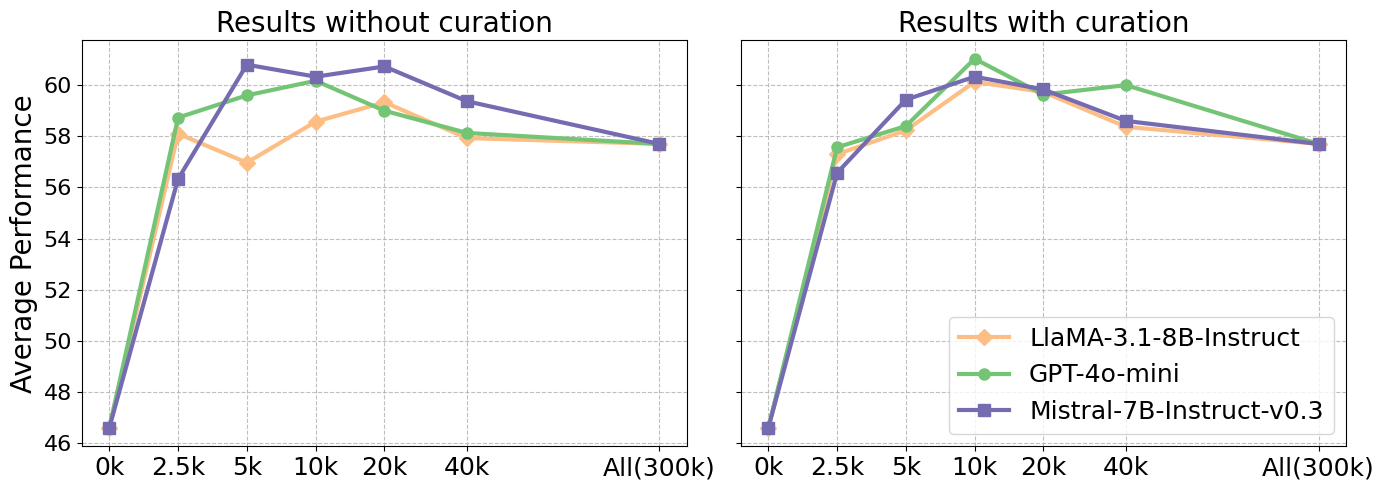

In [145]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件，并设置多级索引
df_mean_rounded = pd.read_csv("data_scaling_final_average.csv", index_col=[0, 1])  
df_std_rounded = pd.read_csv("data_scaling_final_std.csv", index_col=[0, 1])

# 获取 x 轴标签 (data scales)
x_labels = [0, 5, 10, 15, 20, 26, 40]  # 手动设置 x 轴的位置
xticks_labels = ['0k', '2.5k', '5k', '10k', '20k', '40k', 'All(300k)']  # x轴的显示标签

# 创建两个子图，分别用于绘制 filtered 和 filtered-cured
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# 选取 labeling models
labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

# 绘制 filtered 曲线
for labeling_model in labeling_models:
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    if 'llama' in labeling_model.lower():
        axes[0].plot(x_labels, df_subset.loc['filtered'], marker='D', label='LlaMA-3.1-8B-Instruct', color='#fdbe85', linewidth=3, linestyle='-', markersize=8)

    if 'gpt' in labeling_model.lower():
        axes[0].plot(x_labels, df_subset.loc['filtered'], marker='o', label='GPT-4o-mini', color='#74c476', linewidth=3, linestyle='-', markersize=8)

    if 'mistral' in labeling_model.lower():
        axes[0].plot(x_labels, df_subset.loc['filtered'], marker='s', label='Mistral-7B-v0.3', color='#756bb1',  linewidth=3, linestyle='-', markersize=8)
        

# 绘制 filtered-cured 曲线
for labeling_model in labeling_models:
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    filtered_cured_tags = [tag for tag in df_subset.index if 'filtered-cured' in tag]

    if 'llama' in labeling_model.lower():
        axes[1].plot(x_labels, df_subset.loc[filtered_cured_tags[0]], marker='D', label='LlaMA-3.1-8B-Instruct', color='#fdbe85', linewidth=3, linestyle='-', markersize=8)

    if 'gpt' in labeling_model.lower():
        axes[1].plot(x_labels, df_subset.loc[filtered_cured_tags[0]], marker='o', label='GPT-4o-mini', color='#74c476', linewidth=3, linestyle='-', markersize=8)

    if 'mistral' in labeling_model.lower():
        axes[1].plot(x_labels, df_subset.loc[filtered_cured_tags[0]], marker='s', label='Mistral-7B-Instruct-v0.3', color='#756bb1',  linewidth=3, linestyle='-', markersize=8)
        

# 设置第一个子图 (filtered) 的标签和标题
axes[0].set_title('Results without curation', fontsize=20)
axes[0].set_xticks(x_labels)
axes[0].set_xticklabels(xticks_labels, fontsize=18)
axes[0].set_ylabel('Average Performance', fontsize=20)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].grid(True, which='both', linestyle='--', alpha=0.8)

# 设置第二个子图 (filtered-cured) 的标签和标题
axes[1].set_title('Results with curation', fontsize=20)
axes[1].set_xticks(x_labels)
axes[1].set_xticklabels(xticks_labels, fontsize=18)
axes[1].grid(True, which='both', linestyle='--', alpha=0.8)

# 在第一个子图和第二个子图分别添加图例
axes[1].legend(loc='lower right', fontsize=18)

# 调整布局，确保不重叠
plt.tight_layout()

# 显示图像
plt.show()


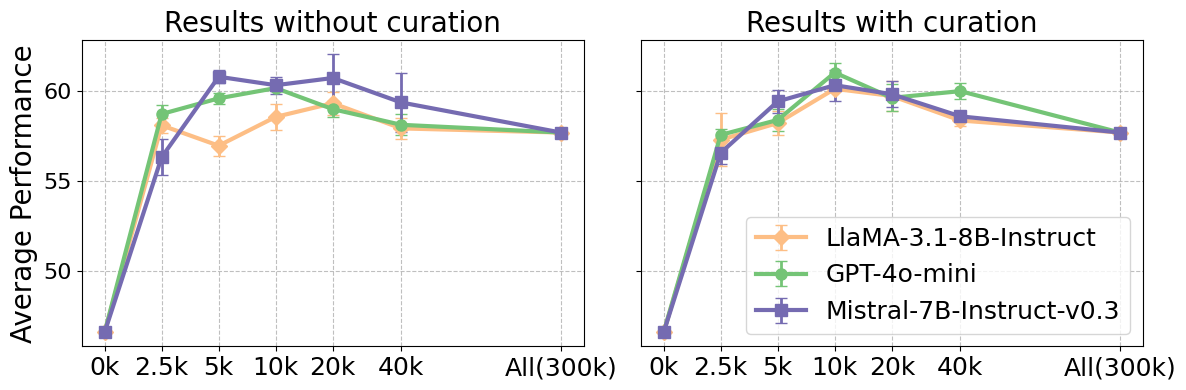

In [157]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件，并设置多级索引
df_mean_rounded = pd.read_csv("data_scaling_final_average.csv", index_col=[0, 1])  
df_std_rounded = pd.read_csv("data_scaling_final_std.csv", index_col=[0, 1])

# 获取 x 轴标签 (data scales)
x_labels = [0, 5, 10, 15, 20, 26, 40]  # 手动设置 x 轴的位置
xticks_labels = ['0k', '2.5k', '5k', '10k', '20k', '40k', 'All(300k)']  # x轴的显示标签

# 创建两个子图，分别用于绘制 filtered 和 filtered-cured
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# 选取 labeling models
labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

# 绘制 filtered 曲线
for labeling_model in labeling_models:
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    df_std_subset = df_std_rounded.xs(labeling_model, level='labeling_model')  # 获取标准差

    if 'llama' in labeling_model.lower():
        axes[0].errorbar(x_labels, df_subset.loc['filtered'], yerr=df_std_subset.loc['filtered'],
                         marker='D', label='LlaMA-3.1-8B-Instruct', color='#fdbe85', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)  # elinewidth 调整误差条线宽

    if 'gpt' in labeling_model.lower():
        axes[0].errorbar(x_labels, df_subset.loc['filtered'], yerr=df_std_subset.loc['filtered'],
                         marker='o', label='GPT-4o-mini', color='#74c476', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)

    if 'mistral' in labeling_model.lower():
        axes[0].errorbar(x_labels, df_subset.loc['filtered'], yerr=df_std_subset.loc['filtered'],
                         marker='s', label='Mistral-7B-v0.3', color='#756bb1',  linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)
        

# 绘制 filtered-cured 曲线
for labeling_model in labeling_models:
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    df_std_subset = df_std_rounded.xs(labeling_model, level='labeling_model')  # 获取标准差

    filtered_cured_tags = [tag for tag in df_subset.index if 'filtered-cured' in tag]

    if 'llama' in labeling_model.lower():
        axes[1].errorbar(x_labels, df_subset.loc[filtered_cured_tags[0]], yerr=df_std_subset.loc[filtered_cured_tags[0]],
                         marker='D', label='LlaMA-3.1-8B-Instruct', color='#fdbe85', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)

    if 'gpt' in labeling_model.lower():
        axes[1].errorbar(x_labels, df_subset.loc[filtered_cured_tags[0]], yerr=df_std_subset.loc[filtered_cured_tags[0]],
                         marker='o', label='GPT-4o-mini', color='#74c476', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)

    if 'mistral' in labeling_model.lower():
        axes[1].errorbar(x_labels, df_subset.loc[filtered_cured_tags[0]], yerr=df_std_subset.loc[filtered_cured_tags[0]],
                         marker='s', label='Mistral-7B-Instruct-v0.3', color='#756bb1',  linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)
        

# 设置第一个子图 (filtered) 的标签和标题
axes[0].set_title('Results without curation', fontsize=20)
axes[0].set_xticks(x_labels)
axes[0].set_xticklabels(xticks_labels, fontsize=18)
axes[0].set_ylabel('Average Performance', fontsize=20)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].grid(True, which='both', linestyle='--', alpha=0.8)

# 设置第二个子图 (filtered-cured) 的标签和标题
axes[1].set_title('Results with curation', fontsize=20)
axes[1].set_xticks(x_labels)
axes[1].set_xticklabels(xticks_labels, fontsize=18)
axes[1].grid(True, which='both', linestyle='--', alpha=0.8)

# 在第一个子图和第二个子图分别添加图例
axes[1].legend(loc='lower right', fontsize=18)

# 调整布局，确保不重叠
plt.tight_layout()

# 显示图像
plt.show()



In [150]:
import pandas as pd

# 假设 df_mean_rounded 已经被加载，并且 x_labels 已经定义
# df_mean_rounded 是多层索引的 DataFrame，含有 'filtered' 和 'filtered-cured' 数据

# 获取 x 轴标签 (data scales)
x_labels = [0, 5, 10, 15, 20, 26, 40]  # 手动设置 x 轴的位置

# 选取 labeling models
labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

# 计算 filtered 的 gap
filtered_gap = []
for i, x_label in enumerate(x_labels):
    values = []
    for labeling_model in labeling_models:
        df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
        values.append(df_subset.loc['filtered'].iloc[i])
    
    # 计算当前 x 位置的最大值和最小值的差
    gap = max(values) - min(values)
    filtered_gap.append(gap)

# 计算 filtered-cured 的 gap
filtered_cured_gap = []
for i, x_label in enumerate(x_labels):
    values = []
    for labeling_model in labeling_models:
        df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
        filtered_cured_tags = [tag for tag in df_subset.index if 'filtered-cured' in tag]
        values.append(df_subset.loc[filtered_cured_tags[0]].iloc[i])
    
    # 计算当前 x 位置的最大值和最小值的差
    gap = max(values) - min(values)
    filtered_cured_gap.append(gap)

# 返回两个 gap 列表
print("Filtered gaps:", filtered_gap)
print("Filtered-cured gaps:", filtered_cured_gap)

# 计算列表的平均值
filtered_gap_avg = sum(filtered_gap) / len(filtered_gap)
filtered_cured_gap_avg = sum(filtered_cured_gap) / len(filtered_cured_gap)

# 打印结果
print("Filtered gap 平均值:", filtered_gap_avg)
print("Filtered-cured gap 平均值:", filtered_cured_gap_avg)


Filtered gaps: [0.0, 2.3999999999999986, 3.8299999999999983, 1.759999999999998, 1.7299999999999969, 1.4399999999999977, 0.0]
Filtered-cured gaps: [0.0, 1.0, 1.2000000000000028, 0.8999999999999986, 0.19999999999999574, 1.6300000000000026, 0.0]
Filtered gap 平均值: 1.5942857142857128
Filtered-cured gap 平均值: 0.7042857142857143
